<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/dev/src/racing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/zhestyatsky/mipt-opt-project.git
import sys
sys.path.append('/content/mipt-opt-project/src')

In [0]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import utils
from spider_boost import spider_boost
from natasha import natasha_15, natasha_2

In [0]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = utils.DatasetWrapper(train_dataset)

In [0]:
class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.conv1(x))
        return outputs

In [0]:
loss = torch.nn.CrossEntropyLoss()
regularizer = utils.regularizer

In [0]:
batch_size = 6000
learning_rate = 0.001
learning_rate_adagrad = 0.001
learning_rate_decay = 0.001
n_epochs = 150

In [0]:
gd_model = CustomModel(784, 10)
gd_mom_model = copy.deepcopy(gd_model)
adagrad_model = copy.deepcopy(gd_model)
adam_model = copy.deepcopy(gd_model)

sb_model = copy.deepcopy(gd_model)
sb_mom_model = copy.deepcopy(gd_model)

n15_model = copy.deepcopy(gd_model)
n2_model = copy.deepcopy(gd_model)

if torch.cuda.is_available():
    gd_model = gd_model.cuda()
    gd_mom_model = gd_mom_model.cuda()
    adagrad_model = adagrad_model.cuda()
    adam_model = adam_model.cuda()
    
    sb_model = sb_model.cuda()
    sb_mom_model = copy.deepcopy(gd_model).cuda()
    
    n15_model = n15_model.cuda()
    n2_model = n2_model.cuda()

In [0]:
gd_opt = torch.optim.SGD(gd_model.parameters(), lr=learning_rate)
gd_mom_opt = torch.optim.SGD(gd_mom_model.parameters(), lr=learning_rate, momentum=0.9)
adagrad_opt = torch.optim.Adagrad(adagrad_model.parameters(), lr=learning_rate_adagrad, lr_decay=learning_rate_decay)
adam_opt = torch.optim.Adam(adam_model.parameters(), lr=learning_rate)

In [9]:
%%time
gd_total_loss = utils.opt_algorithm(gd_opt, train_dataset, batch_size, gd_model, loss, regularizer, n_epochs)

CPU times: user 1min 8s, sys: 1.04 s, total: 1min 9s
Wall time: 1min 9s


In [10]:
%%time
gd_mom_total_loss = utils.opt_algorithm(gd_mom_opt, train_dataset, batch_size, gd_mom_model, loss, regularizer, n_epochs)

CPU times: user 1min 8s, sys: 812 ms, total: 1min 9s
Wall time: 1min 9s


In [11]:
%%time
adagrad_total_loss = utils.opt_algorithm(adagrad_opt, train_dataset, batch_size, adagrad_model, loss, regularizer, n_epochs)

CPU times: user 1min 8s, sys: 858 ms, total: 1min 9s
Wall time: 1min 9s


In [12]:
%%time
adam_total_loss = utils.opt_algorithm(adam_opt, train_dataset, batch_size, adam_model, loss, regularizer, n_epochs)

CPU times: user 1min 7s, sys: 796 ms, total: 1min 8s
Wall time: 1min 8s


In [13]:
%%time
sb_total_loss = spider_boost(train_dataset, batch_size, sb_model, loss, regularizer, learning_rate, n_epochs)

CPU times: user 1min 9s, sys: 794 ms, total: 1min 9s
Wall time: 1min 10s


In [16]:
%%time
sb_mom_total_loss = spider_boost(train_dataset, batch_size, sb_mom_model, loss, regularizer, learning_rate, n_epochs, momentum=0.9)

CPU times: user 1min 10s, sys: 838 ms, total: 1min 11s
Wall time: 1min 11s


In [0]:
#%%time
#n_15_total_loss = natasha_15(train_dataset, batch_size, n15_model, loss, regularizer, learning_rate, n_epochs, sigma=10)

In [0]:
#%%time
#n_2_total_loss = natasha_2(train_dataset, batch_size, n2_model, loss, regularizer, learning_rate, n_epochs)

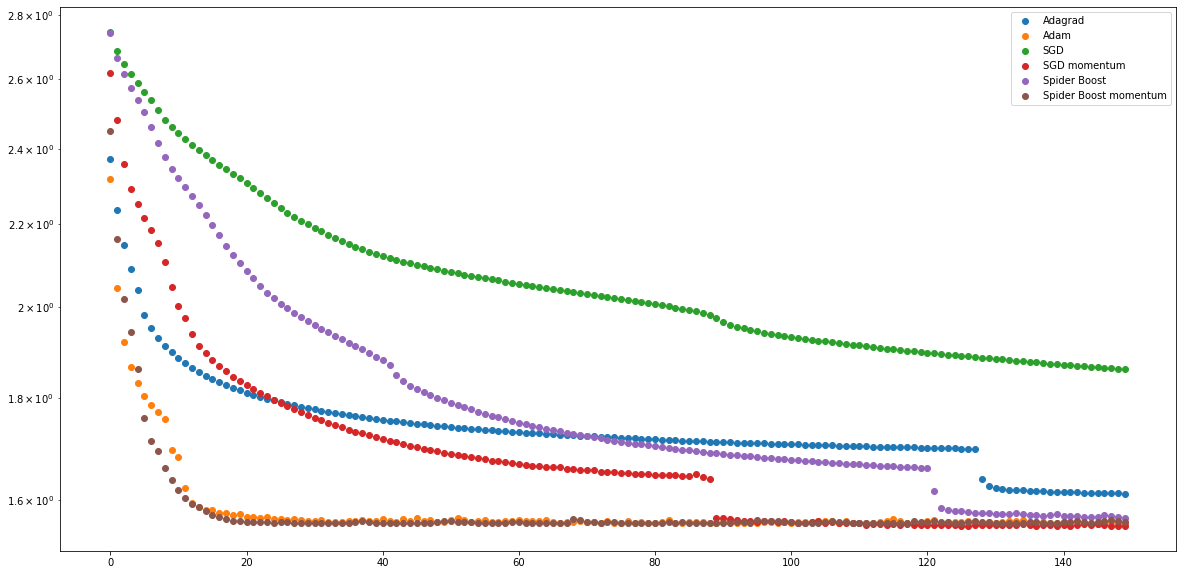

In [17]:
plt.figure(figsize=(20,10))
plt.plot(adagrad_total_loss, 'o', label='Adagrad')
plt.plot(adam_total_loss, 'o', label='Adam')
plt.plot(gd_total_loss, 'o', label='SGD')
plt.plot(gd_mom_total_loss, 'o', label='SGD momentum')
#plt.plot(n_15_total_loss, 'o', label='Natasha 1.5')
#plt.plot(n_2_total_loss, 'o', label='Natasha 2')
plt.plot(sb_total_loss, 'o', label='Spider Boost')
plt.plot(sb_mom_total_loss, 'o', label='Spider Boost momentum')
plt.legend()
plt.semilogy()
plt.show()